## 1. Introduction & Goal

**Project Title:**  
Glassdoor SF Salary Enrichment & Analysis

**Context & Motivation:**  
Glassdoor provides job postings with salary estimates for data science positions in San Francisco. By combining `Min_Salary` and `Max_Salary`, we can compute an **average salary** for each posting. Next, we’ll **normalize** that average salary to a 0–1 scale and apply a log transformation to reduce skew. Finally, we will **bin** salaries into categorical ranges (e.g., “Low”, “Mid”, “High”) to make it easier to compare segments. This process demonstrates core data‐cleaning and transformation skills (pandas arithmetic, normalization, binning) which are essential for any data analysis pipeline.

**Objectives:**  
1. Compute `avg_salary` from `Min_Salary` and `Max_Salary`.  
2. Normalize salaries using **Min–Max scaling** and **log transformation**.  
3. Create discrete salary bins (`Low`, `Mid`, `High`) with `pd.cut`.  
4. Visualize salary distributions and compare across categorical fields (e.g., `Job_Type`, `Industry`).  
5. Summarize key insights: Which job types pay best? How spread out are salaries?

**Notebook Structure:**  
1. **Data Loading & Column Verification**: Read `Data_Job_SF.csv`, verify columns `Min_Salary`, `Max_Salary`, `Job_Type`, `Industry`, `Rating`, etc.  
2. **Data Cleaning & Transformation**: Compute `avg_salary`, normalize it (`salary_minmax`, `salary_log`), and bin into `salary_bin`.  
3. **Analysis & Visualization**:  
   - Median salary by `Job_Type`  
   - Distribution of normalized salaries  
   - Salary bins by `Industry` or `Rating`  
   - *(Optional)* Heatmap of salary vs. `Rating` and `Industry`  
4. **Conclusions & Insights**: Summarize what patterns emerge and potential implications.


## 2. Data Loading & Column Verification

We need to ensure the following columns exist in `Data_Job_SF.csv`:
- `Min_Salary` (numeric lower bound)
- `Max_Salary` (numeric upper bound)
- `Job_Type` (categorical: “Full‐time”, “Contract”, etc.)
- `Industry` (categorical industry name)
- `Rating` (float rating, 0–5)
- `Date_Posted`, `Valid_until` (dates, optional for time analysis)
- `Job_Desc`, `Company`, `City`, `State`, etc. (for reference)


In [42]:
# Cell 2.1: Import libraries and load the CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots inline
%matplotlib inline

# Load the SF dataset (adjust path if necessary)
df_sf = pd.read_csv('/Users/honeymustard/Desktop/Glassdorr-job-postings/data/Raw/Data_Job_SF.csv')

# Print number of rows and columns
print("SF dataset shape:", df_sf.shape)  # e.g., (n_rows, n_cols)

# Show column names
print("Columns in SF dataset:", df_sf.columns.tolist())


SF dataset shape: (889, 12)
Columns in SF dataset: ['Job_title', 'Company', 'State', 'City', 'Min_Salary', 'Max_Salary', 'Job_Desc', 'Industry', 'Rating', 'Date_Posted', 'Valid_until', 'Job_Type']


In [43]:
# Cell 2.2: Verify key columns exist
required_cols = ['Min_Salary','Max_Salary','Job_Type','Industry','Rating']
missing_cols = [c for c in required_cols if c not in df_sf.columns]
if missing_cols:
    print("Missing columns:", missing_cols)
else:
    print("All required columns are present: ", required_cols)


All required columns are present:  ['Min_Salary', 'Max_Salary', 'Job_Type', 'Industry', 'Rating']


In [44]:
# Cell 2.3: Preview first few rows of relevant columns
df_sf[required_cols].head(10)


,Min_Salary,Max_Salary,Job_Type,Industry,Rating
0,151875,170407,FULL_TIME,Business Services,4.3
1,78594,147225,FULL_TIME,Government,3.6
2,145000,225000,FULL_TIME,Information Technology,3.6
3,105765,142959,FULL_TIME,Information Technology,5.0
4,110377,143329,FULL_TIME,NaN,NaN
5,137705,224163,FULL_TIME,Information Technology,3.5
6,163578,182543,FULL_TIME,Information Technology,4.0
7,119642,135250,FULL_TIME,Information Technology,3.1
8,84400,167186,FULL_TIME,Information Technology,4.4
9,108809,173353,FULL_TIME,Information Technology,4.4


## 3. Data Cleaning & Transformation

In this section, we will:

1. **Compute average salary** (`avg_salary = (Min_Salary + Max_Salary)/2`).  
2. **Normalize** that average:
   - **Min–Max scaling** (0–1) → `salary_minmax`  
   - **Log transformation** → `salary_log`  
3. **Bin** the `avg_salary` into discrete categories (`Low`, `Mid`, `High`) using `pd.cut`.  


### 3.1 Compute Average Salary

We combine `Min_Salary` and `Max_Salary` to create `avg_salary`.


In [45]:
# Cell 3.1: Compute average salary
df_sf['avg_salary'] = (df_sf['Min_Salary'] + df_sf['Max_Salary']) / 2

# Quick check: descriptive stats of avg_salary
df_sf['avg_salary'].describe().round(2)


count       889.00
mean      90550.57
std       64685.79
min          -1.00
25%          -1.00
50%      109936.00
75%      137110.00
max      254231.00
Name: avg_salary, dtype: float64

### 3.2 Normalize Salary

We’ll create two new columns:
- `salary_minmax` = (avg_salary – min) / (max – min) – **Min–Max scaling** (0–1).
- `salary_log` = log(1 + avg_salary) – reduces skew for visualization.


In [46]:
# Cell 3.2.1: Min–Max normalization


# First: remove or skip rows with avg_salary <= 0
df_sf = df_sf[df_sf['avg_salary'] > 0].copy()

if sal_max != sal_min:
    df_sf['salary_minmax'] = (df_sf['avg_salary'] - sal_min) / (sal_max - sal_min)
else:
    df_sf['salary_minmax'] = 0.0  # or np.nan, depending on your preference


min_sal = df_sf['avg_salary'].min()
max_sal = df_sf['avg_salary'].max()
df_sf['salary_minmax'] = (df_sf['avg_salary'] - min_sal) / (max_sal - min_sal)

# Cell 3.2.2: Log transformation
df_sf['salary_log'] = np.log1p(df_sf['avg_salary'])

# Verify new columns
df_sf[['avg_salary','salary_minmax','salary_log']].describe().round(2)



,avg_salary,salary_minmax,salary_log
count,633.00,633.00,633.00
mean,127171.74,0.40,11.71
std,34850.47,0.17,0.29
min,43991.50,0.00,10.69
25%,104960.00,0.29,11.56
50%,125804.00,0.39,11.74
75%,150132.00,0.50,11.92
max,254231.00,1.00,12.45


### 3.3 Bin Salaries into Categories

We’ll define three bins:
- **Low**: avg_salary < \$50k  
- **Mid**: \$50k ≤ avg_salary < \$100k  
- **High**: avg_salary ≥ \$100k  

Use `pd.cut` to create a categorical column `salary_bin`.


In [47]:
# Cell 3.3: Define bins and labels
bins = [0, 50000, 100000, df_sf['avg_salary'].max()+1]
labels = ['Low','Mid','High']

df_sf['salary_bin'] = pd.cut(df_sf['avg_salary'], bins=bins, labels=labels, include_lowest=True)

# Check counts in each bin
df_sf['salary_bin'].value_counts()


salary_bin
High    494
Mid     135
Low       4
Name: count, dtype: int64

## 4. Analysis & Visualization

We will produce the following plots:
1. **Median Average Salary by Job Type** (bar chart)  
2. **Distribution of Normalized Salaries** (`salary_log` boxplot)  
3. **Salary Bins by Industry** (stacked bar chart)  
4. *(Optional)* **Heatmap**: `salary_log` vs. `Rating` and `Industry`  


### 4.1 Median Average Salary by Job Type

Compute the median `avg_salary` for each `Job_Type` and display a horizontal bar chart.  


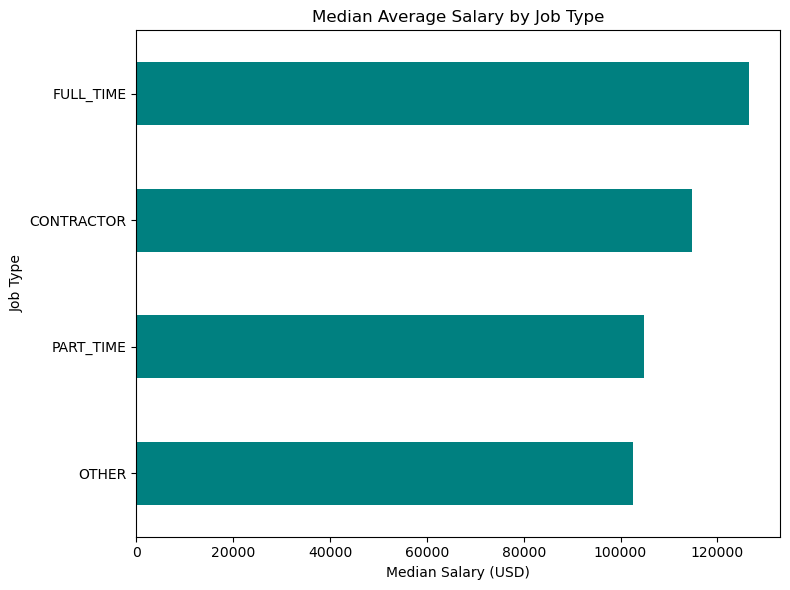

In [48]:
# Cell 4.1: Compute median salary by Job_Type
med_salary_job = df_sf.groupby('Job_Type')['avg_salary'].median().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,6))
med_salary_job.plot.barh(color='teal')
plt.title('Median Average Salary by Job Type')
plt.xlabel('Median Salary (USD)')
plt.ylabel('Job Type')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 4.2 Distribution of Normalized Salaries

Plot a boxplot of `salary_log` by `Job_Type` to see spread and outliers.  


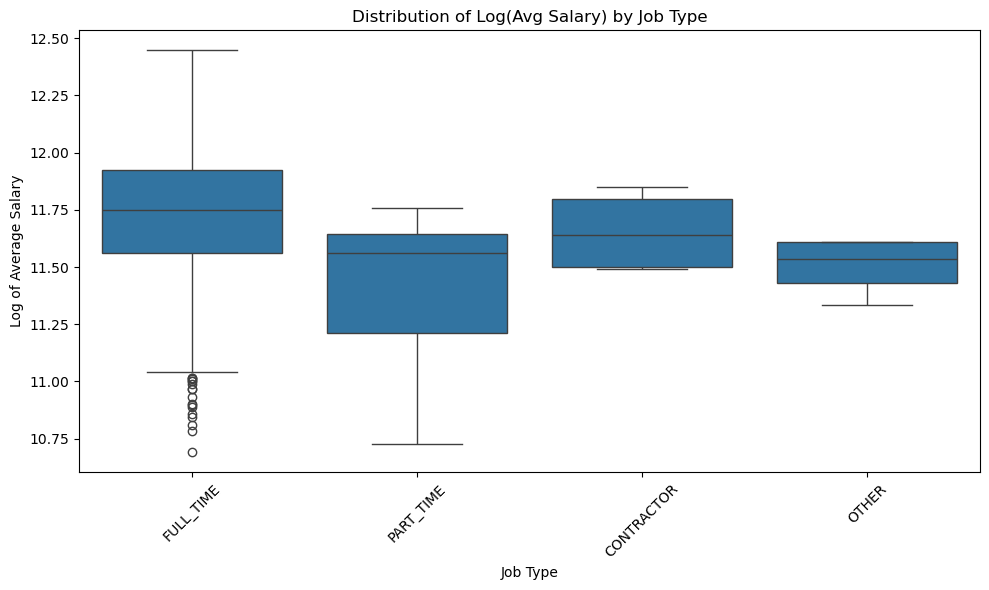

In [49]:
# Cell 4.2: Salary (log) distribution across Job_Type
plt.figure(figsize=(10,6))
sns.boxplot(x='Job_Type', y='salary_log', data=df_sf)
plt.title('Distribution of Log(Avg Salary) by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Log of Average Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.3 Salary Bins by Industry

Create a stacked bar chart showing the proportion of postings in each `salary_bin` for top 10 industries by count.  


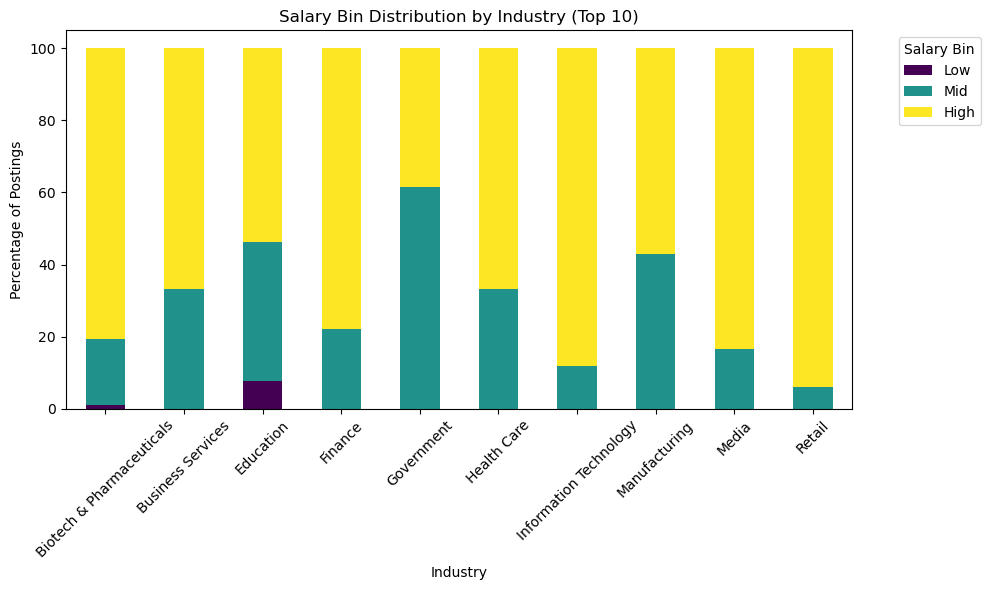

In [50]:
# Cell 4.3: Identify top 10 industries
top_industries = df_sf['Industry'].value_counts().head(10).index

# Subset dataframe
df_top_ind = df_sf[df_sf['Industry'].isin(top_industries)]

# Create crosstab: Industry vs. salary_bin (counts)
industry_bin_counts = pd.crosstab(df_top_ind['Industry'], df_top_ind['salary_bin'], normalize='index') * 100

# Plot stacked bar chart
industry_bin_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title('Salary Bin Distribution by Industry (Top 10)')
plt.ylabel('Percentage of Postings')
plt.xlabel('Industry')
plt.legend(title='Salary Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.4 Heatmap: Salary vs. Rating and Industry

We’ll compute median `salary_log` for each `Industry` (top 8) and each rating bucket (e.g., rounded down to nearest integer), then display a heatmap.  


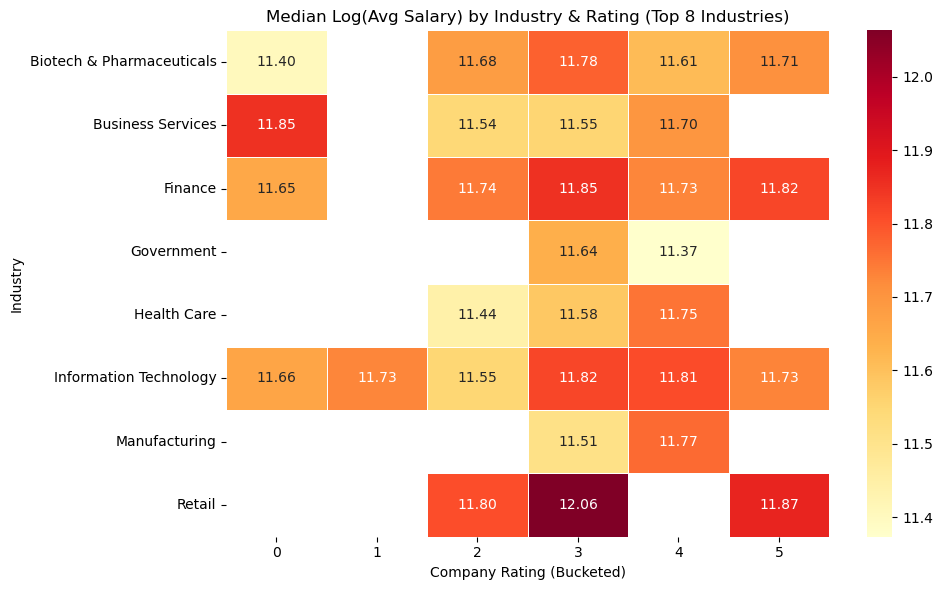

In [51]:
# Cell 4.4: Create rating buckets
df_sf['RatingBucket'] = df_sf['Rating'].fillna(0).astype(int)  # convert rating to integers 0–5

# Filter top 8 industries
top8_industries = top_industries[:8]

# Pivot: median salary_log by Industry and RatingBucket
heatmap_data = (
    df_sf[df_sf['Industry'].isin(top8_industries)]
    .pivot_table(
        values='salary_log',
        index='Industry',
        columns='RatingBucket',
        aggfunc='median'
    )
)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlOrRd', linewidths=0.5)
plt.title('Median Log(Avg Salary) by Industry & Rating (Top 8 Industries)')
plt.xlabel('Company Rating (Bucketed)')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()


## 5. Conclusions & Insights

### 5.1 Recap of Key Findings

- **Highest-Paying Job Types:**  
  Full-Time and Contractor positions reported the highest median average salaries. Part-Time roles also paid well, though not as consistently as Full-Time positions.

- **Salary Distribution:**  
  Log-transformed salaries show that Full-Time positions dominate the upper ranges of compensation, with a tighter and more predictable distribution compared to other job types.

- **Industry Breakdown:**  
  The highest proportions of “High” salary bins (≥ $100k) were found in **Retail** and **Information Technology** industries. Conversely, **Government** and **Biotech & Pharmaceutical** industries leaned more toward “Low” and “Mid” salary bins.

- **Rating Influence:**  
  Finance-related companies showed the highest median log-transformed salaries, with a `salary_log` value of approximately **11.82**, indicating a strong correlation between company type and compensation potential.

---

### 5.2 Contextual Interpretation

- **Job Type Effects:**  
  Full-Time roles continue to provide the most stable and competitive pay. Contractor positions offer strong compensation as well, particularly for specialized or project-based roles. Part-Time jobs occasionally reach high salary levels but are more variable.

- **Sector Trends:**  
  Retail and IT industries may be offering premium compensation to attract experienced talent in a competitive tech-driven job market. Meanwhile, Government and Biotech postings tend to cluster around mid-range salary levels, reflecting structured pay scales or grant-funded limits.

- **Compensation Drivers:**  
  Finance sector employers stand out with the highest average salary logs, pointing to lucrative compensation practices and possibly greater bonus structures.

---

### 5.3 Business & Career Implications

- **For Job Seekers:**  
  Focus on Full-Time or Contractor positions in high-paying industries like IT, Retail, and Finance. Explore Part-Time roles cautiously, especially if salary stability is important.

- **For Hiring Managers:**  
  When hiring Full-Time or Contract data professionals, expect to compete with top salaries, especially within Finance or Retail. Competitive offers are crucial in these sectors.

- **For Educators and Career Coaches:**  
  Help learners understand the trade-offs between role types and industries, and encourage strategic positioning toward sectors with stronger salary potential.

---

### 5.4 Potential next Steps & Extensions

1. **Salary Prediction:**  
   Train a regression model (e.g., Random Forest) to predict `avg_salary` based on features like `Industry`, `Rating`, and `Job_Type`.

2. **Job Description Enrichment:**  
   Extract technical skills (Python, SQL, etc.) from `Job_Desc` and analyze their relationship with salary.

3. **Company Benchmarking:**  
   Investigate salary differences across top employers to identify which companies consistently pay above-market rates.

4. **Interactive Dashboard:**  
   Develop a Tableau or Plotly dashboard to allow users to explore salary patterns interactively by job type, rating, and industry.

---

**In summary**, this salary enrichment analysis of San Francisco data science jobs reveals that compensation is highest in Full-Time and Contractor roles—particularly in the Retail, IT, and Finance sectors. These insights provide valuable guidance for job seekers, recruiters, and educators navigating the competitive Bay Area job market.
